# Generate videos with different moving directions

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import cv2
import numpy as np
from PIL import Image
import imageio
import json
import os

width, height = 400, 400
motion_directions = ["assets/motion_direction/direction_left.json",
                     "assets/motion_direction/direction_right.json",
                     "assets/motion_direction/direction_up.json",
                     "assets/motion_direction/direction_down.json",
                     "assets/motion_direction/direction_still.json"]
scene_directions = ["assets/images/scene1.jpg",
                     "assets/images/scene2.jpg"]
output_video_path = "output/videos"
os.makedirs(output_video_path, exist_ok=True)

for motion_direction in motion_directions:
    with open(motion_direction) as f:
        velocity_list = json.load(f)['direction']

    for scene_direction in scene_directions:
        x = 0
        y = 0
        color_numpy_array = []
        for idx, velocity in enumerate(velocity_list):
            output_path = os.path.join(output_video_path, motion_direction.split("/")[-1].split(".")[0]+"_"+scene_direction.split("/")[-1].split(".")[0]+".gif")
            image = Image.open(scene_direction)
            image_width, image_height = image.size
            array = np.array(image)
            x += velocity[0]
            y += velocity[1]
            frame = array[y+image_height//2:y+image_height//2+height,x+image_width//2:x+image_width//2+width]
            color_numpy_array.append(frame)

        modified_frames = [frame + np.random.randint(0, 2, frame.shape, dtype=np.uint8) for frame in color_numpy_array] # prevent saving optimization
        imageio.mimsave(output_path, modified_frames, duration=0.2)

# Get intermediate feature from DDIM inversion

In [ ]:
from utils import do_inversion, load_pipeline
import os

video_path = ["output/videos/direction_down_scene1.gif",
              "output/videos/direction_down_scene2.gif",
              "output/videos/direction_up_scene1.gif",
              "output/videos/direction_up_scene2.gif",
              "output/videos/direction_right_scene1.gif",
              "output/videos/direction_right_scene2.gif",
              "output/videos/direction_left_scene1.gif",
              "output/videos/direction_left_scene2.gif",
              "output/videos/direction_still_scene1.gif",
              "output/videos/direction_still_scene2.gif",]
outpath = ["output/inter_feat/direction_down_scene1.pt",
           "output/inter_feat/direction_down_scene2.pt",
           "output/inter_feat/direction_up_scene1.pt",
           "output/inter_feat/direction_up_scene2.pt",
           "output/inter_feat/direction_right_scene1.pt",
           "output/inter_feat/direction_right_scene2.pt",
           "output/inter_feat/direction_left_scene1.pt",
           "output/inter_feat/direction_left_scene2.pt",
           "output/inter_feat/direction_still_scene1.pt",
           "output/inter_feat/direction_still_scene2.pt",]

os.makedirs('output/inter_feat', exist_ok=True)

pipeline = load_pipeline()
do_inversion(pipeline, video_path, outpath)

# PCA

## with Content Correlation Removal

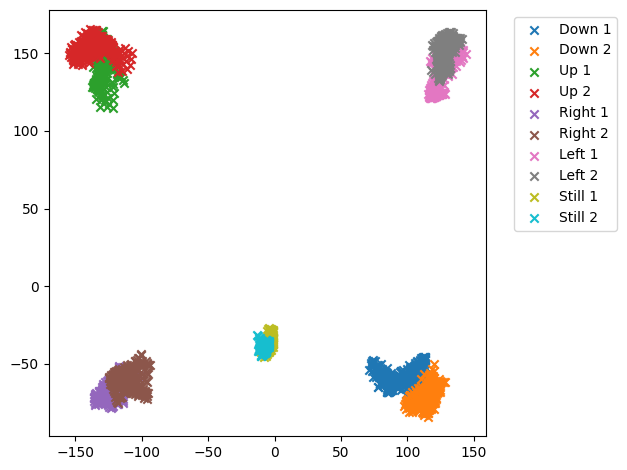

In [4]:
import torch
import torch.nn.functional as F
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

data_list = [
    "output/inter_feat/direction_down_scene1.pt",
    "output/inter_feat/direction_down_scene2.pt",
    "output/inter_feat/direction_up_scene1.pt",
    "output/inter_feat/direction_up_scene2.pt",
    "output/inter_feat/direction_right_scene1.pt",
    "output/inter_feat/direction_right_scene2.pt",
    "output/inter_feat/direction_left_scene1.pt",
    "output/inter_feat/direction_left_scene2.pt",
    "output/inter_feat/direction_still_scene1.pt",
    "output/inter_feat/direction_still_scene2.pt",
]

total_data_num = len(data_list)

frame_num = 16

data_tensor_origin = None
for i, path in enumerate(data_list):
    data = torch.load(path)
    data = F.interpolate(data, [64, 64], mode='bilinear').to(torch.float32)

    b,c,h,w = data.shape
    crop_size = 16
    data = data[:,:,h//2-crop_size//2:h//2+crop_size//2,w//2-crop_size//2:w//2+crop_size//2]

    data = data.reshape(frame_num,c,crop_size,crop_size)
    data = data - data.mean(dim=0, keepdim=True)
    data = data[0]
    data = data.reshape(c,crop_size,crop_size)
    data = data[None]


    if data_tensor_origin is None:
        data_tensor_origin = data
    else:
        data_tensor_origin = torch.cat([data_tensor_origin, data],dim=0)


data_tensor = data_tensor_origin#.cuda()
data_tensor = data_tensor.permute(0,2,3,1).reshape(total_data_num*crop_size*crop_size,c)

# Center the data (subtract mean)
mean = torch.mean(data_tensor, dim=0) # ~= 0
centered_data = data_tensor - mean

# Calculate the covariance matrix
covariance_matrix = torch.mm(centered_data.t(), centered_data) / (data_tensor.size(0) - 1)

# Calculate eigenvalues and eigenvectors using torch.linalg.eig
eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)
eigenvalues = eigenvalues.to(torch.float)
eigenvectors = eigenvectors.to(torch.float)

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = torch.argsort(eigenvalues[:], descending=True)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Choose the top k principal components
k = 2
principal_components = eigenvectors[:, :k]
projected_data = torch.mm(data_tensor, principal_components).detach()#.cpu()
color = np.zeros([total_data_num*crop_size*crop_size*1])

for i in range(total_data_num):
    color[i*crop_size*crop_size*1:(i+1)*crop_size*crop_size*1] = i/total_data_num

labels = ["Down 1", "Down 2", "Up 1", "Up 2", "Right 1", "Right 2", "Left 1", "Left 2", "Still 1", "Still 2"]

handles = []
for i in range(total_data_num): 
    handle = plt.scatter(projected_data[i*crop_size*crop_size*1:(i+1)*crop_size*crop_size*1,0].numpy(), projected_data[i*crop_size*crop_size*1:(i+1)*crop_size*crop_size*1,1].numpy(), label=labels[i], marker='x')
    handles.append(handle)

plt.legend(handles=handles, bbox_to_anchor=(1.05,1.0))
    
plt.tight_layout()
plt.savefig('output/pca_moft.png')
plt.show()
plt.close()

## without Content Correlation Removal

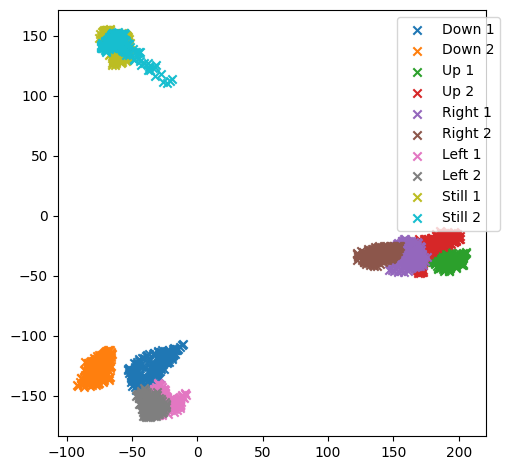

In [7]:
import torch
import torch.nn.functional as F
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

data_list = [
    "output/inter_feat/direction_down_scene1.pt",
    "output/inter_feat/direction_down_scene2.pt",
    "output/inter_feat/direction_up_scene1.pt",
    "output/inter_feat/direction_up_scene2.pt",
    "output/inter_feat/direction_right_scene1.pt",
    "output/inter_feat/direction_right_scene2.pt",
    "output/inter_feat/direction_left_scene1.pt",
    "output/inter_feat/direction_left_scene2.pt",
    "output/inter_feat/direction_still_scene1.pt",
    "output/inter_feat/direction_still_scene2.pt",
]

total_data_num = len(data_list)

frame_num = 16

data_tensor_origin = None
for i, path in enumerate(data_list):
    data = torch.load(path)
    data = F.interpolate(data, [64, 64], mode='bilinear').to(torch.float32)

    b,c,h,w = data.shape
    crop_size = 16
    data = data[:,:,h//2-crop_size//2:h//2+crop_size//2,w//2-crop_size//2:w//2+crop_size//2]

    data = data.reshape(frame_num,c,crop_size,crop_size)
    # data = data - data.mean(dim=0, keepdim=True) # only modify this
    data = data[0]
    data = data.reshape(c,crop_size,crop_size)
    data = data[None]


    if data_tensor_origin is None:
        data_tensor_origin = data
    else:
        data_tensor_origin = torch.cat([data_tensor_origin, data],dim=0)


data_tensor = data_tensor_origin# .cuda()
data_tensor = data_tensor.permute(0,2,3,1).reshape(total_data_num*crop_size*crop_size,c)

# Center the data (subtract mean)
mean = torch.mean(data_tensor, dim=0) # ~= 0
centered_data = data_tensor - mean

# Calculate the covariance matrix
covariance_matrix = torch.mm(centered_data.t(), centered_data) / (data_tensor.size(0) - 1)

# Calculate eigenvalues and eigenvectors using torch.linalg.eig
eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)
eigenvalues = eigenvalues.to(torch.float)
eigenvectors = eigenvectors.to(torch.float)

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = torch.argsort(eigenvalues[:], descending=True)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Choose the top k principal components
k = 2
principal_components = eigenvectors[:, :k]

projected_data = torch.mm(data_tensor, principal_components).detach()# .cpu()
color = np.zeros([total_data_num*crop_size*crop_size*1])

for i in range(total_data_num):
    color[i*crop_size*crop_size*1:(i+1)*crop_size*crop_size*1] = i/total_data_num

labels = ["Down 1", "Down 2", "Up 1", "Up 2", "Right 1", "Right 2", "Left 1", "Left 2", "Still 1", "Still 2"]

handles = []
for i in range(total_data_num): 
    handle = plt.scatter(projected_data[i*crop_size*crop_size*1:(i+1)*crop_size*crop_size*1,0].numpy(), projected_data[i*crop_size*crop_size*1:(i+1)*crop_size*crop_size*1,1].numpy(), label=labels[i], marker='x')
    handles.append(handle)

plt.legend(handles=handles, bbox_to_anchor=(1.05,1.0))
    
plt.tight_layout()
plt.savefig('output/pca_moft_wo_CCR.png')
plt.show()
plt.close()

# Motion Channel Filter

In [5]:
import torch
import torch.nn.functional as F
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

data_list = [
    "output/inter_feat/direction_left_scene1.pt",
    "output/inter_feat/direction_left_scene2.pt",
    "output/inter_feat/direction_right_scene1.pt",
    "output/inter_feat/direction_right_scene2.pt"
]

total_data_num = len(data_list)

frame_num = 16

data_tensor_origin = None
for i, path in enumerate(data_list):
    data = torch.load(path)
    data = F.interpolate(data, [64, 64], mode='bilinear').to(torch.float32)

    b,c,h,w = data.shape
    crop_size = 16
    data = data[:,:,h//2-crop_size//2:h//2+crop_size//2,w//2-crop_size//2:w//2+crop_size//2]

    data = data.reshape(frame_num,c,crop_size,crop_size)
    data = data - data.mean(dim=0, keepdim=True)
    data = data[0]
    data = data.reshape(c,crop_size,crop_size)
    data = data[None]


    if data_tensor_origin is None:
        data_tensor_origin = data
    else:
        data_tensor_origin = torch.cat([data_tensor_origin, data],dim=0)


data_tensor = data_tensor_origin.cuda()
data_tensor = data_tensor.permute(0,2,3,1).reshape(total_data_num*crop_size*crop_size,c)

# Center the data (subtract mean)
mean = torch.mean(data_tensor, dim=0) # ~= 0
centered_data = data_tensor - mean

# Calculate the covariance matrix
covariance_matrix = torch.mm(centered_data.t(), centered_data) / (data_tensor.size(0) - 1)

# Calculate eigenvalues and eigenvectors using torch.linalg.eig
eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)
eigenvalues = eigenvalues.to(torch.float)
eigenvectors = eigenvectors.to(torch.float)

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = torch.argsort(eigenvalues[:], descending=True)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Choose the top k principal components
k = 2
principal_components = eigenvectors[:, :k]
_,idx = torch.sort(principal_components[:,0].abs(), descending=True)

print(idx[:50])
torch.save(idx[:50], "output/horizontal_dims.pt")


tensor([1194,  722,  983,  159, 1107, 1122,  637,  411, 1067,  626,  662,  874,
          89,  473,  973,   76,  318, 1052, 1090,  780,  587, 1095,  107,  170,
         755, 1102,  475, 1109, 1066,   11,  310, 1229,  748,  421,  919,  407,
          20,    0,  627,  879,  497,  428,  859,  588, 1063, 1239,  167,  391,
        1084, 1019], device='cuda:0')


# Get MOFT from real videos

In [ ]:
from utils import do_inversion, load_pipeline
import os

video_path = ["assets/videos/car.gif",
              "assets/videos/goose.mp4"]
outpath = ["output/inter_feat/car.pt",
           "output/inter_feat/goose.pt"]

pipeline = load_pipeline()
do_inversion(pipeline, video_path, outpath)

# Calculate similarity between MOFT

0.7565607
-0.30387825
(np.int64(235), np.int64(365))


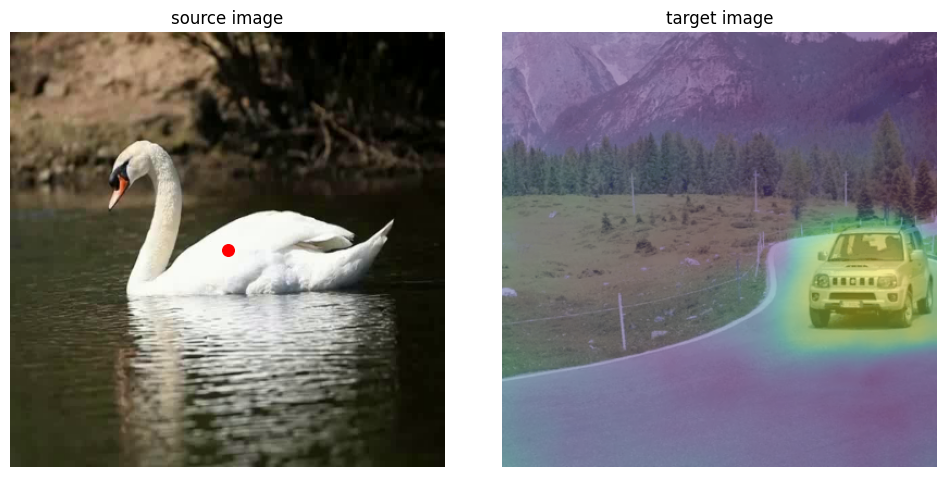

In [7]:
import torch
import torch.nn.functional as F
from utils import Demo, convert_mp4_to_png

dim_mask = torch.load("output/horizontal_dims.pt").cpu()
ft_1 = torch.load('output/inter_feat/goose.pt', map_location='cpu')
ft_1 = ft_1[:,dim_mask]
ft_1 = ft_1 - ft_1.mean(dim=0, keepdim=True)
ft_1 = ft_1[0:1]
ft_1 = F.interpolate(ft_1, (64, 64), mode='bilinear').reshape(-1,64,64)

ft_2 = torch.load('output/inter_feat/car.pt', map_location='cpu').float()
ft_2 = ft_2[:,dim_mask]
ft_2 = ft_2 - ft_2.mean(dim=0, keepdim=True)
ft_2 = ft_2[0:1]
ft_2 = F.interpolate(ft_2, (64, 64), mode='bilinear').reshape(-1,64,64)

ft = torch.stack([ft_1,ft_2],dim=0)

imglist = []

img_size = 400
ensemble_size = 8

filelist = [["assets/videos/goose.mp4",0], ["assets/videos/car.gif",0]]


for filename in filelist:
    imglist.append(convert_mp4_to_png(filename[0], filename[1]))

demo = Demo(imglist, ft, img_size=400)
demo.ft = demo.ft.float()
demo.plot_img_pairs(fig_size=5, x=200, y=200, output_path='output/similarity.png')

# View the trend in motion channels

In [ ]:
import cv2
import numpy as np
from PIL import Image
import imageio
import json
import os

width, height = 400, 400
motion_directions = ["assets/motion_direction/direction_rightleft.json",
                     "assets/motion_direction/direction_rightleftright.json"]
scene_directions = ["assets/images/scene1.jpg",
                     "assets/images/scene2.jpg"]
output_video_path = "output/videos"

for motion_direction in motion_directions:
    with open(motion_direction) as f:
        velocity_list = json.load(f)['direction']

    for scene_direction in scene_directions:
        x = 0
        y = 0
        color_numpy_array = []
        for idx, velocity in enumerate(velocity_list):
            output_path = os.path.join(output_video_path, motion_direction.split("/")[-1].split(".")[0]+"_"+scene_direction.split("/")[-1].split(".")[0]+".gif")
            image = Image.open(scene_direction)
            image_width, image_height = image.size
            array = np.array(image)
            x += velocity[0]
            y += velocity[1]
            frame = array[y+image_height//2:y+image_height//2+height,x+image_width//2:x+image_width//2+width]
            color_numpy_array.append(frame)

        modified_frames = [frame + np.random.randint(0, 2, frame.shape, dtype=np.uint8) for frame in color_numpy_array] # prevent saving optimization
        imageio.mimsave(output_path, modified_frames, duration=0.2)

# Get the MOFT

from utils import do_inversion, load_pipeline
import os

video_path = ["output/videos/direction_rightleft_scene1.gif",
              "output/videos/direction_rightleft_scene2.gif",
              "output/videos/direction_rightleftright_scene1.gif",
              "output/videos/direction_rightleftright_scene2.gif",]
outpath = ["output/inter_feat/direction_rightleft_scene1.pt",
           "output/inter_feat/direction_rightleft_scene2.pt",
           "output/inter_feat/direction_rightleftright_scene1.pt",
           "output/inter_feat/direction_rightleftright_scene2.pt"]

pipeline = load_pipeline()
do_inversion(pipeline, video_path, outpath)

output/inter_feat/direction_right_scene1.pt
torch.Size([16, 1280, 64, 64])
output/inter_feat/direction_right_scene2.pt
torch.Size([16, 1280, 64, 64])
output/inter_feat/direction_left_scene1.pt
torch.Size([16, 1280, 64, 64])
output/inter_feat/direction_left_scene2.pt
torch.Size([16, 1280, 64, 64])
output/inter_feat/direction_rightleft_scene1.pt
torch.Size([16, 1280, 64, 64])
output/inter_feat/direction_rightleft_scene2.pt
torch.Size([16, 1280, 64, 64])
output/inter_feat/direction_rightleftright_scene1.pt
torch.Size([16, 1280, 64, 64])
output/inter_feat/direction_rightleftright_scene2.pt
torch.Size([16, 1280, 64, 64])


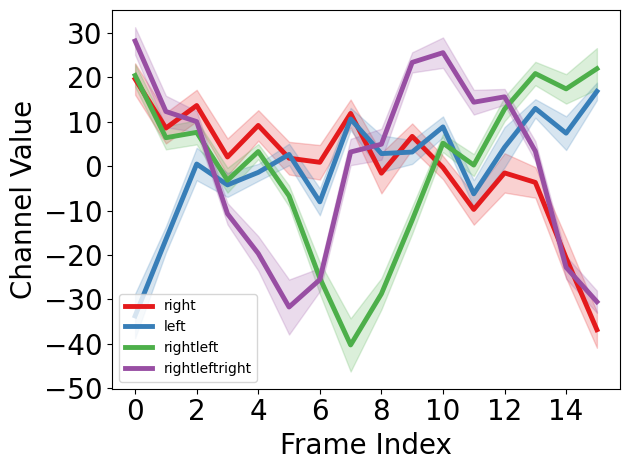

In [8]:
from matplotlib import pyplot as plt
import torch

feat_list = [
    ['output/inter_feat/direction_right_scene1.pt',
     'output/inter_feat/direction_right_scene2.pt'],
    ['output/inter_feat/direction_left_scene1.pt',
     'output/inter_feat/direction_left_scene2.pt'],
    ['output/inter_feat/direction_rightleft_scene1.pt',
     'output/inter_feat/direction_rightleft_scene2.pt'],
    ['output/inter_feat/direction_rightleftright_scene1.pt',
     'output/inter_feat/direction_rightleftright_scene2.pt'],
]

label = ['right', 'left', 'rightleft', 'rightleftright']


palette = plt.get_cmap('Set1')
def draw_line(name_of_alg,color_index,datas):
    color=palette(color_index)
    avg=np.mean(datas,axis=0)
    std=np.std(datas,axis=0)
    iters=list(range(16))
    r1 = list(map(lambda x: x[0]-x[1], zip(avg, std)))#上方差
    r2 = list(map(lambda x: x[0]+x[1], zip(avg, std)))#下方差
    handle, = plt.plot(iters, avg, color=color,label=name_of_alg, linewidth=3.5)
    plt.fill_between(iters, r1, r2, color=color, alpha=0.2)
    return handle

handles = []
for idx, feat in enumerate(feat_list):

    f_list = []
    for f in feat:
        x = np.zeros(16*1*1)
        for i in range(16):
            x[i*1*1:(i+1)*1*1] = i

        print(f)
        a = torch.load(f)
        print(a.shape)

        a1 = a
        a1 = a1 - a1.mean(0)[None]
        y = a1[:,1194,5:20,5:20].reshape(16,-1).permute(1,0).cpu().numpy()
        f_list.append(y)
    y = np.concatenate(f_list, axis=0)
    handles.append(draw_line(label[idx], idx,y))

legend = plt.legend(handles=handles)

plt.xlabel('Frame Index', size = 20)
plt.ylabel('Channel Value', size = 20)

plt.xticks(size = 20)
plt.yticks(size = 20)

plt.tight_layout()
# # 添加图例
plt.legend()

# 显示图形
plt.show()
plt.savefig("output/channel_vis_1194.png")
plt.close()

# Use MOFT for Video Motion Control

In [ ]:
# Generate an origin video
from utils import load_pipeline, save_videos_grid
import torch

pipeline = load_pipeline()

prompt = "close up photo of two cats sitting in a room"
negative_prompt = "semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate"
latents = torch.load("assets/initial_latents/double_cats.pt")
sample = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=25,
    guidance_scale=7.5,
    width=512,
    height=512,
    video_length=16,
    latents=latents,
    motion_guide=False
).videos

save_videos_grid(sample, "output/origin.gif")

In [ ]:
# Motion control - single point

sample = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=25,
    guidance_scale=7.5,
    width=512,
    height=512,
    video_length=16,
    motion_guide=True,
    latents=latents,
    motion_guidance_weight=6,
    mask_path=["assets/masks/cat_left.png"],
    dim_mask_path=['output/horizontal_dims.pt'],
    reference_moft_path=['output/inter_feat/direction_rightleft_scene1.pt']
).videos

save_videos_grid(sample, "output/single_point.gif")

In [ ]:
# Motion control - multiple points

sample = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=25,
    guidance_scale=7.5,
    width=512,
    height=512,
    video_length=16,
    motion_guide=True,
    latents=latents,
    motion_guidance_weight=8,
    mask_path=["assets/masks/cat_left.png", "assets/masks/cat_right.png"],
    dim_mask_path=['output/horizontal_dims.pt','output/horizontal_dims.pt'],
    reference_moft_path=['output/inter_feat/direction_rightleft_scene1.pt', 'output/inter_feat/direction_rightleft_scene1.pt']
).videos

save_videos_grid(sample, "output/multi_points.gif")